# **Matrix** **Multiplication**

---



Input - 2 matrices of compatible sizes ('m1', 'm2')

Output - Sum of elements of matrix obtained by multiplying 'm1', 'm2'

In [0]:
import numpy as np
import pickle as pk
from google.colab import files
import cv2

def multiply_matrices(m1, m2):
    if not (m1.shape == m2.shape):
        raise Exception('Matrices are not of the same dimenstion', m1.shape, m2.shape, 'are not compatible')
    prod = m1*m2
    return np.sum(prod)

# **Fully Connected Layer**

---
Neurons in a fully connected layer have full connections to all activations in the previous layer. Their activations can hence be computed with a matrix multiplication followed by a bias offset. 

Input - Input matrix [C x W x H] , weights [(C*W*H) x M] , bias [M x 1]

Output - Output of FC Layer [1 x M]

In [0]:
def flatten(ip):
  out = None
  C, W, H = ip.shape
  reshaped_input = ip.reshape((1, int(C*W*H)))
  return reshaped_input  

In [0]:
def fullyconnected(ip, weights, bias=None):
  if bias is None:
    out = np.dot(ip, weights)
  else:
    out = np.dot(ip, weights) + bias
  return out

# **Activation Layers**

---

**ReLU (Rectified Linear Unit)**

ReLU layer will apply an elementwise activation function 'max(0,x)'  i.e. thresholding at zero. This leaves the size of the volume unchanged.

![RELU](https://cdn-images-1.medium.com/max/937/1*oePAhrm74RNnNEolprmTaQ.png)




---
**Softmax Activation**

The softmax function squashes the outputs of each unit to be between 0 and 1 and it also divides each output such that the total sum of the outputs is equal to 1.
The output of the softmax function is equivalent to a categorical probability distribution, it tells you the probability that any of the classes are true.

![Softmax](https://cloud.githubusercontent.com/assets/14886380/22743247/9eb7c856-ee54-11e6-98ca-a7e03120b1f8.png)




In [0]:
class Activation:
    ## act_type: 0 = ReLU
    ##           1 = Softmax
    ##           2 = Sigmoid
    ## ip_type: 0 = ReLU for conv layer
    ## ip_type: 1 = ReLU for dense layer
    def __init__(self, ip, act_type, ip_type=0):
        self.ip = ip
        self.act_type = act_type
        self.ip_type = ip_type
    
    def relu(self):
      if (self.ip_type == 0):
        input = self.ip  
        relu_out = np.zeros(input.shape)  
        for map_num in range(input.shape[-1]):  
            for r in np.arange(0,input.shape[0]):  
                for c in np.arange(0, input.shape[1]):
                    if input[r, c, map_num] > 0:
                      relu_out[r, c, map_num] = input[r, c, map_num]
        return relu_out 
      else:
        input = self.ip
        relu_out = np.zeros(input.shape)        
        for r in np.arange(0,input.shape[0]):  
          for c in np.arange(0, input.shape[1]):
            if input[r, c] > 0:
              relu_out[r, c] = input[r, c]
        return relu_out

    def softmax(self): 
        out = np.exp(self.ip) 
        return out / np.sum(out)

    def forward_pass(self):
        if (self.act_type == 0):
            return self.relu()
        if (self.act_type == 1):
            return self.softmax()

# **Convolution Layer**


---

Convolution layer will compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. 


![Convolution](https://media.giphy.com/media/i4NjAwytgIRDW/giphy.gif)

# **Zero padding**

---

Sometimes it will be convenient to pad the input volume with zeros around the border. The size of this zero-padding is a hyperparameter. The nice feature of zero padding is that it will allow us to control the spatial size of the output volumes


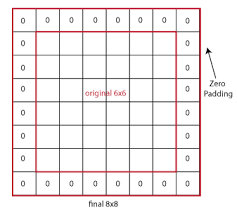

# **Stride**

---

The stride specifies the value with which we slide the filter. When the stride is 1 then we move the filters one pixel at a time. When the stride is 2 (or uncommonly 3 or more, though this is rare in practice) then the filters jump 2 pixels at a time as we slide them around. This will produce smaller output volumes spatially.

**In the gif below, stride is 2**

![alt text](http://deeplearning.net/software/theano/_images/numerical_padding_strides.gif)

# **Pooling**

Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network, and hence to also control overfitting. The Pooling Layer operates independently on every depth slice of the input and resizes it spatially, using the MAX operation. The most common form is a pooling layer with filters of size 2x2 applied with a stride of 2 downsamples every depth slice in the input by 2 along both width and height, discarding 75% of the activations.

![alt text](https://www.cntk.ai/jup/c103d_max_pooling.gif)

In [0]:
def pooling(ip, pool_size=2, stride=2):  
  num_channels, ip_size, _ = ip.shape
  #out_size = ip_size - pool_size // stride
  pool_out = np.zeros((num_channels, (ip_size - pool_size)//stride + 1, (ip_size - pool_size)//stride + 1))
  for map_num in range(num_channels):
    r2 = 0
    for r in np.arange(0, ip_size - pool_size + 1, stride):  
      c2 = 0
      for c in np.arange(0, ip_size - pool_size + 1, stride):
        for row in ip[map_num][r:r+pool_size]:
          for column in row[c:c+pool_size]:
            if (pool_out[map_num, r2, c2] < column):
              pool_out[map_num, r2, c2] = column
        c2 = c2 + 1  
      r2 = r2 +1  
  return pool_out

# Load Pre Trained Model Weights

Load pre trained model weights, trained on CIFAR 10 dataset

In [0]:
def uploader():
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('user uploaded file {name} with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

In [0]:
def loader(input_weights_file):
  weights = pk.load(open(input_weights_file, 'rb'))
  n_weights = {}
  for layer_name in weights:
    w = weights[layer_name]
    if not (len(w) == 0):
      if 'conv' in layer_name:
        n_weights[layer_name] = np.array(w[0]).T   #np.rollaxis(np.rollaxis(np.array(w[0]), 3, 0), 3, 1)
      if 'dense' in layer_name:
        n_weights[layer_name] = w[0]
  return n_weights

# **Model Definition**


![alt text](https://raw.githubusercontent.com/IshaanMudgal/IITB-DL-Workshop/master/Capture.PNG)

In [0]:
import numpy as np
import pickle
import cv2

data = unpickle('cifar-10-batches-py/data_batch_1')
data.keys()

In [0]:
def extractImagesAndLabels(path, file):
    f = open(path+file, 'rb')
    dicts = pickle.load(f, encoding='bytes')
    images = dicts[b'data']
    images = np.reshape(images, (10000, 3, 32, 32))
    labels = dicts[b'labels']
    imagearray = np.array(images)
    labelarray = np.array(labels)
    return imagearray, labelarray

def extractCategories(path, file):
    f = open(path+file, 'rb')
    dicts = pickle.load(f)
    return dicts['label_names']

def saveCifarImage(array, path, file):
    # array is 3x32x32. cv2 needs 32x32x3
    array = array.transpose(1,2,0)
    # array is RGB. cv2 needs BGR
    array = cv2.cvtColor(array, cv2.COLOR_RGB2BGR)
    # save to PNG file
    return cv2.imwrite(path+file+".png", array)

imgarray, lblarray = extractImagesAndLabels("cifar-10-batches-py/", "data_batch_1")
print(imgarray.shape)
print(lblarray.shape)

categories = extractCategories("cifar-10-batches-py/", "batches.meta")

cats = []
for i in range(0,10):
    saveCifarImage(imgarray[i], "./cifar10_images/", "image"+(str)(i))
    category = np.array(lblarray[i])
    category = (int(category))
    cats.append(categories[category])
print(cats)

(10000, 3, 32, 32)
(10000,)
['frog', 'truck', 'truck', 'deer', 'automobile', 'automobile', 'bird', 'horse', 'ship', 'cat']


In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
#data = unpickle('')

In [0]:
from keras.datasets import cifar10
(X_train,y_train), (X_test,y_test) = cifar10.load_data()

In [0]:
import numpy as np

end_points = {}
NUM_CLASSES = 10
uploader()

Saving CIFAR_weights_rolled to CIFAR_weights_rolled
user uploaded file CIFAR_weights_rolled with length 6705530 bytes


In [0]:
filename = 'CIFAR_weights_rolled'
m_weights = loader(filename)

### Load preweights for the network ###
convlayer1_kernels = m_weights['conv2d_1']
convlayer2_kernels = m_weights['conv2d_2']
convlayer3_kernels = m_weights['conv2d_3']
convlayer4_kernels = m_weights['conv2d_4']
denselayer1_weights = np.array(m_weights['dense_1'])
denselayer2_weights = np.array(m_weights['dense_2'])

(64, 32, 3, 3)


In [0]:
class ConvLayer():
    def __init__(self, layer_type, ip, kernels, stride=1, padding=1):
        self.layer_type = layer_type
        self.ip = ip
        self.padding = padding
        self.stride = stride
        self.kernels = kernels
        return
    
    def _conv_maps(self, cmap, kernel):
        ip_size, ip_size = cmap.shape
        kernel_size, kernel_size = kernel.shape
        output_size = int((ip_size - kernel_size + self.padding)/self.stride)
        #### Create a new padded input map
        padded_size = ip_size + self.padding
        cmap_padded = np.zeros([padded_size, padded_size])
        for col in range(padded_size):
            for row in range(padded_size):
                if (row >= ip_size) or (col >= ip_size):
                    break
                cmap_padded[row + self.padding//2, col + self.padding//2] = cmap[row, col]

        #### Compute the output map
        output_map = np.zeros([ip_size, ip_size])
        try:
            for c in range(ip_size):
                for r in range(ip_size):
                    m1 = cmap_padded[c:c+(kernel_size - self.padding//2 + 1), r:r + (kernel_size - self.padding//2 + 1)]
                    output_map[c][r] = multiply_matrices(m1, kernel)
        except Exception as e:
            print(e)
        return output_map
      
    def _conv_3d_maps(self, cmap, kernel):
      num_channels, ip_size, ip_size = cmap.shape
      num_kernel_channels, kernel_size, kernel_size = kernel.shape
      if not (num_channels == num_kernel_channels):
        print("Mismatch in number of channels of kernel and input image")
      output_size = int((ip_size - kernel_size + self.padding)/self.stride)
      #### Create a new padded input map
      padded_size = ip_size + self.padding
      cmap_padded = np.zeros([num_channels, padded_size, padded_size])
      for c in range(num_channels):
        for col in range(padded_size):
            for row in range(padded_size):
                if (row >= ip_size) or (col >= ip_size):
                    break
                cmap_padded[c, row + self.padding//2, col + self.padding//2] = cmap[c, row, col]

      #### Compute the output map
      output_size, output_size = (padded_size - kernel_size)//self.stride + 1, (padded_size - kernel_size)//self.stride + 1
      output_map_3d = np.zeros([output_size, output_size])
      stride = self.stride
      try:
          cmap_iter_row = kernel_size // 2          
          out_col, out_row = 0, 0
          while (out_row < output_size):
              if (cmap_iter_row + kernel_size//2 + 1 > padded_size):
                #print("BREAK1")
                break
              out_col = 0
              cmap_iter_col = kernel_size // 2 
              while (out_col < output_size):                  
                  if (cmap_iter_col + kernel_size//2 + 1 > padded_size):
                    break
                  m1 = cmap_padded[:, cmap_iter_row - kernel_size//2:cmap_iter_row + kernel_size//2 + 1, cmap_iter_col - kernel_size//2:cmap_iter_col + kernel_size//2 + 1]
                  output_map_3d[out_row][out_col] = np.sum(multiply_matrices(m1, kernel))                 
                  cmap_iter_col += stride                  
                  out_col += 1
              out_row += 1
              cmap_iter_row += stride

      except Exception as e:
          print(e)
          
      return output_map_3d

    def forward_pass(self):
        this_input = self.ip
        ip_depth, ip_size, ip_size = this_input.shape
        num_kernels, kernel_depth, kernel_size, kernel_size = self.kernels.shape
        outputs = []
        for kernel_id in range(num_kernels):
          out_map = np.zeros((ip_size, ip_size))
          out_map = self._conv_3d_maps(this_input, self.kernels[kernel_id])
          outputs.append(out_map)
        return np.array(outputs)

    def test(self):
        cmap = np.ones([5, 10, 10])
        print(cmap.shape)
        self.ip = cmap
        out = self.forward_pass()
        print(out[0].shape)



In [0]:
from PIL import Image
inputs = Image.open('cifar10_images/image0.png')
inputs = np.array(inputs)
inputs = inputs.T #np.rollaxis(inputs, 2, 0)

inputs.shape

(3, 32, 32)

In [0]:
##### ConvLayer1 #####
layer1_stride = 1
layer1_padding = 2
layer1 = ConvLayer(1, inputs, convlayer1_kernels, layer1_stride, layer1_padding)
layer1_out = layer1.forward_pass()
end_points['convlayer1'] = layer1_out
print("convlayer1 output ready")

##### Act1 #####
act1_inputs = layer1_out
act1 = Activation(act1_inputs, 0)
act1_outs = act1.forward_pass()
end_points['act1'] = act1_outs
print(act1_outs.shape)
print(act1_outs[:, 11, 5])

convlayer1 output ready
(32, 32, 32)
[26.12792886 27.17737738  2.71886375 22.73427187  0.          3.63419392
 10.92617407 71.60864685 14.19427808 26.34139935  9.59704561 15.31502198
 33.4791548  29.86943034  0.         47.80157814 33.54173714 37.41098969
  3.40548129  2.12105108 13.85435526 16.35328179  8.06284727 10.44482682
 18.28303231  0.          0.82307874  0.         12.8475696   0.
 12.48848038  0.        ]


In [0]:
##### ConvLayer2 #####
layer2_inputs = act1_outs
layer2_stride = 1
layer2_padding = 0
layer2 = ConvLayer(2, layer2_inputs, convlayer2_kernels, layer2_stride, layer2_padding)
layer2_out = layer2.forward_pass()
end_points['convlayer2'] = layer2_out

##### Act2 #####
act2_inputs = layer2_out
act2 = Activation(act2_inputs, 0)
act2_outs = act2.forward_pass()
end_points['act2'] = act2_outs

In [0]:
#### MaxPool #####
pool_inputs = act2_outs
pool_outs = pooling(pool_inputs, pool_size=2, stride=2)
print(pool_outs.shape)

In [0]:
##### ConvLayer3 #####
layer3_inputs = pool_outs
layer3_stride = 1
layer3_padding = 2
layer3 = ConvLayer(2, layer3_inputs, convlayer3_kernels, layer3_stride, layer3_padding)
layer3_out = layer3.forward_pass()
end_points['convlayer3'] = layer3_out
print("conv3 outputs ready")

##### Act3 #####
act3_inputs = layer3_out
act3 = Activation(act3_inputs, 0)
act3_outs = act3.forward_pass()
end_points['act3'] = act3_outs
print(act3_outs.shape)

In [0]:
##### ConvLayer4 #####
layer4_inputs = act3_outs
layer4_stride = 1
layer4_padding = 2
layer4 = ConvLayer(4, layer4_inputs, convlayer4_kernels, layer4_stride, layer4_padding)
layer4_out = layer4.forward_pass()
end_points['convlayer4'] = layer4_out
print("conv4 outputs ready")

##### Act4 #####
act4_inputs = layer4_out
act4 = Activation(act4_inputs, 0)
act4_outs = act4.forward_pass()
end_points['act4'] = act4_outs
print(act4_outs.shape)

conv4 outputs ready
(64, 15, 15)
[  0.           0.         175.69071423   0.           0.
 114.53115689  44.97442348   0.           0.          52.95552138
  50.98536717   0.          96.13496836   0.          53.81752963
   0.          53.85306116 114.69066805 143.97076769   0.
   9.64679862   1.44705332   0.          31.04929598   0.
  19.96903942   0.          87.18096282   7.61223217   0.
  45.9275365    0.         100.88500155  26.49785512   0.
   0.          63.62250246  44.14073104   0.         131.87034231
   0.          23.20774273   0.           0.          22.56073487
  60.8067447    0.           0.          91.9633625   53.35419854
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.          95.6159015    0.        ]


In [0]:
  uploader()

In [0]:
#### MaxPool2 #####
pool2_inputs = act4_outs
pool2_outs = pooling(pool2_inputs, pool_size=2, stride=2)
print(pool2_outs.shape)

In [0]:
flattened_out = flatten(pool2_outs.T)
##### Dense 3 #####
denselayer1_inputs = flattened_out
denselayer1_outs = fullyconnected(denselayer1_inputs, denselayer1_weights)
## Normalization
#denselayer1_outs = denselayer1_outs/np.max(denselayer1_outs)
end_points['FC'] = denselayer1_outs
print(denselayer1_inputs.shape)

##### Act5 #####
act5_inputs = denselayer1_outs
act5 = Activation(act5_inputs, 0, 1)
act5_outs = act5.forward_pass()
end_points['act5'] = act5_outs
print(act5_outs.shape)

In [0]:
##### Dense 4 #####
denselayer2_inputs = act5_outs
denselayer2_outs = fullyconnected(denselayer2_inputs, denselayer2_weights)
## Normalization
#denselayer2_outs = denselayer2_outs/np.max(denselayer2_outs)
end_points['FC'] = denselayer2_outs

[[-1873.16151632 -2642.79908102   -17.58973522   306.06752917
     83.59143845    69.08362883  1897.53372175  -424.51099236
  -2821.61247977 -3115.48194229]]


In [0]:
##### final Activation #####
print(np.mean(denselayer2_outs))
print(np.var(denselayer2_outs))
#finalact_inputs = (denselayer2_outs - np.mean(denselayer2_outs))/np.var(denselayer2_outs)
finalact_inputs = denselayer2_outs/np.max(denselayer2_outs)
finalact = Activation(finalact_inputs, 1)
finalact_outs = finalact.forward_pass()
end_points['finalact'] = finalact_outs

print(end_points['finalact'])
print(np.sum(finalact_outs))


In [0]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
index = np.argmax(finalact_outs)
predicted_class = class_names[index]
print(predicted_class)

frog
